In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [38]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [39]:
len(words)

32033

In [40]:
# build the vocabulary of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [130]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    X, Y = [], []
    for w in words: 
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182661, 3]) torch.Size([182661])
torch.Size([22763, 3]) torch.Size([22763])
torch.Size([22722, 3]) torch.Size([22722])


In [131]:
# MLP revisited 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurous in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size ** 0.5) #0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [132]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [133]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [134]:
# same optimizatin as last time
max_step = 20000
batch_size = 32
lossi = []

for i in range(max_step):
    # minibach contruct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass 
    for p in parameters: 
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters: 
        p.data += -lr * p.grad
        
    # track status 
    if i % 1000 == 0:
        print (f'{i:7d}/{max_step:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    # break
    

    

      0/  20000:3.3243
   1000/  20000:2.4720
   2000/  20000:2.2296
   3000/  20000:2.3879
   4000/  20000:1.9221
   5000/  20000:2.4457
   6000/  20000:1.7284
   7000/  20000:2.4135
   8000/  20000:2.0479
   9000/  20000:2.3789
  10000/  20000:2.3051
  11000/  20000:2.2930
  12000/  20000:1.7996
  13000/  20000:2.2473
  14000/  20000:2.1842
  15000/  20000:2.0780
  16000/  20000:2.0404
  17000/  20000:1.9940
  18000/  20000:1.8484
  19000/  20000:1.9918


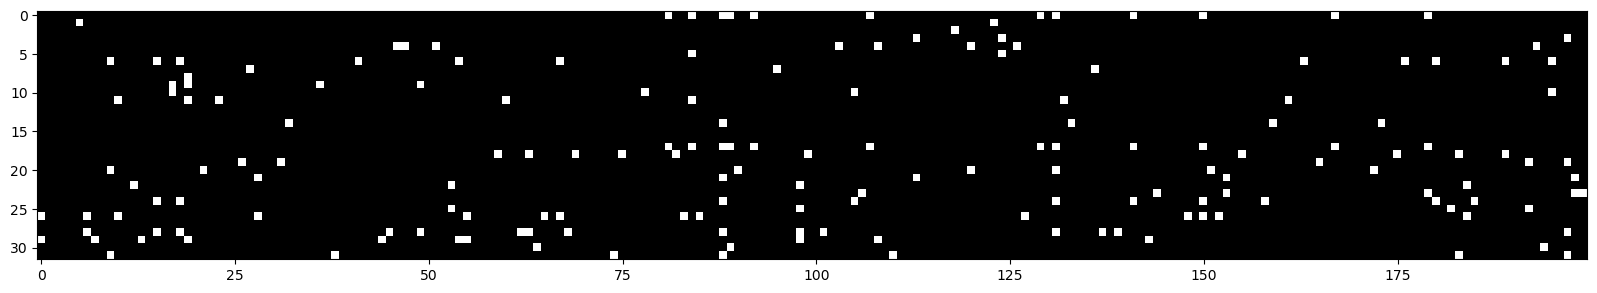

In [135]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([337., 258., 160., 158., 129., 126., 135., 103., 101.,  92., 110.,
         99.,  91., 116., 100., 138., 103., 102., 106., 106., 114., 120.,
        110., 111.,  97., 131., 125., 107.,  98.,  85., 113., 119., 105.,
         94., 114.,  89., 117., 100.,  87., 109., 116., 112., 108., 131.,
        134., 145., 181., 160., 222., 276.]),
 array([-9.99877930e-01, -9.59882752e-01, -9.19887574e-01, -8.79892396e-01,
        -8.39897218e-01, -7.99902040e-01, -7.59906862e-01, -7.19911684e-01,
        -6.79916506e-01, -6.39921328e-01, -5.99926150e-01, -5.59930972e-01,
        -5.19935794e-01, -4.79940616e-01, -4.39945438e-01, -3.99950260e-01,
        -3.59955082e-01, -3.19959904e-01, -2.79964726e-01, -2.39969548e-01,
        -1.99974370e-01, -1.59979192e-01, -1.19984014e-01, -7.99888361e-02,
        -3.99936581e-02,  1.51991844e-06,  3.99966979e-02,  7.99918759e-02,
         1.19987054e-01,  1.59982232e-01,  1.99977410e-01,  2.39972588e-01,
         2.79967766e-01,  3.19962944e-01,  3.59958

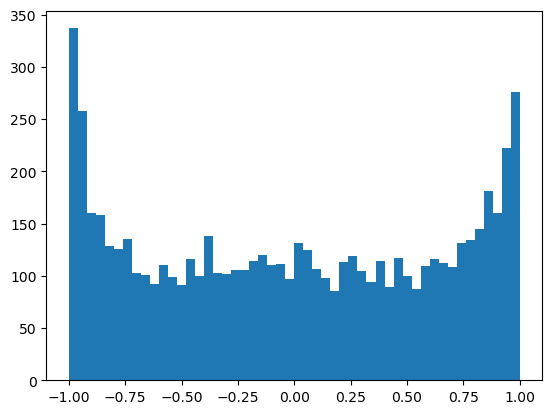

In [136]:
plt.hist(h.view(-1).tolist(), 50)

(array([  3.,   0.,   0.,   3.,   2.,   2.,   3.,   5.,  15.,  16.,  35.,
         44.,  53.,  62., 100., 134., 152., 145., 204., 235., 280., 314.,
        436., 451., 550., 520., 491., 379., 331., 290., 244., 228., 162.,
        115., 124.,  71.,  62.,  43.,  30.,  29.,  12.,   9.,   6.,   2.,
          3.,   1.,   0.,   3.,   0.,   1.]),
 array([-4.85195541, -4.65762329, -4.46329117, -4.26895905, -4.07462692,
        -3.8802948 , -3.68596268, -3.49163055, -3.29729843, -3.10296631,
        -2.90863419, -2.71430206, -2.51996994, -2.32563782, -2.13130569,
        -1.93697357, -1.74264145, -1.54830933, -1.3539772 , -1.15964508,
        -0.96531296, -0.77098083, -0.57664871, -0.38231659, -0.18798447,
         0.00634766,  0.20067978,  0.3950119 ,  0.58934402,  0.78367615,
         0.97800827,  1.17234039,  1.36667252,  1.56100464,  1.75533676,
         1.94966888,  2.14400101,  2.33833313,  2.53266525,  2.72699738,
         2.9213295 ,  3.11566162,  3.30999374,  3.50432587,  3.69865799,
 

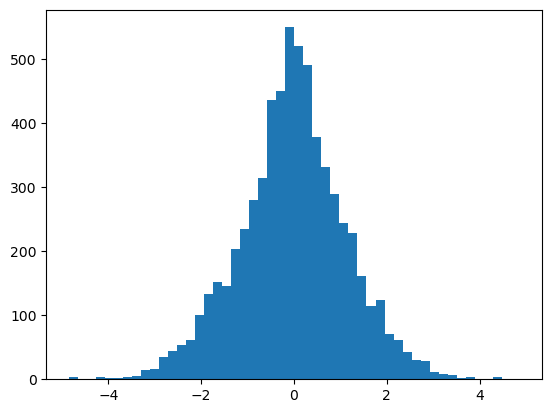

In [137]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [138]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [139]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2052834033966064
val 2.2185914516448975


In [129]:
# sample from the model
from numpy import block


g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True: 
        # forward pass the neural net 
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        # sample from the distribution 
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break 
        if ix == 0:
            break 
    print(''.join(itos[i] for i in out)) # decode and print the generated word
        
     
 

chrelleqycynl.
mfk.
myleglatylencella.
jaxhubefrin.
rhc.
muqeig.
lumalitzirihvin.
lugynd.
shuvlir.
qhinn.
shonn.
milandq.
mucthmmikarbidx.
khushivraxwendellia.
gtlelly.
fryn.
sannova.
musyn.
smbroson.
luclynn.
